In [1]:
import pandas as pd
import numpy as np
import MATTE
print(MATTE.__version__)
import sklearn
print(sklearn.__version__)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1.2.2
1.0.2


# Preprocess

In [ ]:
# read data.
df = pd.read_table("./BRCA_tpm_unstranded.tsv",index_col=0)
df.index = [i.split(".")[0] for i in df.index]

reflabels = pd.read_csv('./BRCA_subtype_ich_group.csv',index_col=0)
reflabels.index += '-01A'
reflabels.loc[(reflabels[['er_status_by_ihc','pr_status_by_ihc','her2_status_by_ihc']]=='Negative').all(axis=1),'TNBC'] = 'TNBC'
reflabels.loc[(reflabels[['er_status_by_ihc','pr_status_by_ihc','her2_status_by_ihc']]=='Positive').any(axis=1),'TNBC'] = 'others'

df_pheno = reflabels['TNBC'].dropna()
samples = df.columns & df_pheno.index
df = df.loc[:,samples]
df_pheno = df_pheno[samples]

In [ ]:
# filter gene
import dill as pickle
with open('./Result_file/BRCA_corr_diste12_121.pkl','rb') as f:
    Rdc = pickle.load(f)
with open('./Result_file/BRCA_mean_dista12_121.pkl','rb') as f:
    Rde = pickle.load(f)
filtered_genes = Rdc.res.index[((~Rdc.res['matched']) & (~Rde.res['matched']))]

df = df.loc[filtered_genes.drop_duplicates(),:]
df = df.drop_duplicates()
df = df[~df.index.duplicated()]

# Run Matte

In [ ]:
from MATTE import AlignPipe
pipe = AlignPipe()
pipe.funcs.pop(1) # delete tpm transform
R = pipe.calculate(df_exp=df,df_pheno=df_pheno,verbose=False)

# from tqdm import tqdm
# res = {}
# for n in [4,6,8,10,12,14,18,24]:
#     tmpt['cluster_properties'] = {}
#     pipe.cluster_func[0].add_params(n_clusters=n)
#     res[n] = pipe.calculate_from_temp(tmpt_result=tmpt,verbose=False)
#     print(n,res[n].cluster_properties['score'])

import dill as pickle
with open('./Result_file/TNBC_mean_dista8.pkl','wb') as f:
    pickle.dump(R,f)

In [ ]:
from MATTE import AlignPipe
pipe = AlignPipe(stats_type='corr')
pipe.funcs.pop(1) # delete tpm transform
R = pipe.calculate(df_exp=df,df_pheno=df_pheno,verbose=False)

# from tqdm import tqdm
# res = {}
# for n in [4,6,8,10,12,14,18,24]:
#     tmpt['cluster_properties'] = {}
#     pipe.cluster_func[0].add_params(n_clusters=n)
#     res[n] = pipe.calculate_from_temp(tmpt_result=tmpt,verbose=False)
#     print(n,res[n].cluster_properties['score'])

import dill as pickle
with open('./Result_file/TNBC_corr_dista8.pkl','wb') as f:
    pickle.dump(R,f)

# Analysis

In [4]:
import dill as pickle
with open('./Result_file/TNBC_mean_dista8.pkl','rb') as f:
    Rde = pickle.load(f)
with open('./Result_file/TNBC_corr_dista8.pkl','rb') as f:
    Rdc = pickle.load(f)

## TNBC and others

In [7]:
sfe = Rde.SampleFeature()
sfc = Rdc.SampleFeature(corr=True)
sfe.columns+='_de'
sfc.columns+='_dc'
snre = Rde.ModuleSNR(sfe)
snrc = Rdc.ModuleSNR(sfc)

In [93]:
sf = pd.merge(
    sfe.loc[:,snre[snre>=1.4].index&(pd.Index([k+'_0_de' for k,v in Rde.module_genes.items() if len(v) >=10]))],
    sfc.loc[:,snrc[snrc>=1.4].index&(pd.Index([k+'_0_dc' for k,v in Rdc.module_genes.items() if len(v) >=10]))],
    right_index=True,left_index=True
)

sfn = (sf-sf.mean())/sf.std() #normalize(sf,axis=0)
sf = pd.DataFrame(sfn,index=sf.index,columns=sf.columns)

In [98]:
interested_modules = sf.columns
mgsxy = {}
for m in interested_modules:
    if 'de' in m:
        mgsxy[m] = Rde.module_genes[m[0:4]]
    elif 'dc' in m:
        mgsxy[m] = Rdc.module_genes[m[0:4]]
    else:
        print(m);raise

In [167]:
from sklearn.cluster import KMeans
cls = KMeans(n_clusters=2)
cls.fit_predict(sf)
label = pd.Series(cls.labels_,index=sf.index)

#sns.heatmap(pd.crosstab(label,Rde.pheno,normalize='columns'),annot=True,fmt='.2f')

In [187]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
def Fig_SampleFeature(
        sample_feature, labels,
        model=None, weighted_distcance=False, metric='euclidean',ax=None,**kwargs):
    model = PCA(n_components=2) if model is None else model
    if weighted_distcance:
        psf = abs(sample_feature.weight_distance(metric=metric))
        psf = model.fit_transform(psf)
    else:
        psf = model.fit_transform(sample_feature)

    if not hasattr(model, "fit_transform"):
        raise TypeError("model has no method named fit_transform.")

    Samples = sample_feature.index
    labels = labels[Samples]
    if ax is None:
        fig,ax = plt.subplots()
    for i, l in enumerate(labels.unique()):
        ax.scatter(
            x=psf[labels == l][:, 0], y=psf[labels == l][:, 1],
            alpha=.8, label=l, color=matplotlib.cm.Paired(i/len(labels.unique())),
            **kwargs
        )
    #plt.legend(loc='best', shadow=False, scatterpoints=1)
    return ax


In [4]:
import os
df_funcs = []
for file in os.listdir('./Result_file/'):
    if file.endswith('func.txt'):
        dff = pd.read_table(os.path.join('./Result_file',file))
        dff['module'] = file[5:14].replace('_0_','')
        df_funcs.append(dff)
df_funcs= pd.concat(df_funcs)
df_func_vis = df_funcs.groupby(by='module').apply(lambda x: x.sort_values(by='Benjamini')[0:3])

In [375]:
#f,ax = plt.subplots(dpi=300)
def Fig_function(ax):
    cm = plt.get_cmap('crest_r')
    module_color = {
        m:plt.get_cmap('Set1')(i)
        for i,m in enumerate(df_func_vis['module'].unique())
    }
    logp = -np.log10(df_func_vis['PValue'])
    ax.barh(
        width = df_func_vis['%'],y=range(df_func_vis.shape[0]),
        color = [cm(i) for i in logp]
    )
    cbar = plt.colorbar(
        matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=logp.min(),vmax=logp.max()),
            cmap=cm),ax=ax,
        
    )
    cbar.set_ticks([1,2,3])
    cbar.set_label('-log$_\mathrm{10}$P-value',fontsize=8)
    cbar.set_ticklabels(ticklabels =[1,2,3] ,fontsize=8)
    ax.set_xlabel('Ratio(%)')
    #ax.set_ylabel('Item')
    ax.set_yticks(range(df_func_vis.shape[0]))
    ax.set_yticklabels(
        [' '.join(i.replace(':','~').split('~')[-1].replace(',','').split()[0:3]) for i in df_func_vis['Term']],
    )
    for i,item in enumerate(ax.get_yticklabels()):
        m = df_func_vis.iloc[i,:]['module']
        item.set_color(module_color[m])

    for i,m in enumerate(df_func_vis['module'].unique()):
        ax.text(
            s=m,color=module_color[m],
            x=1.01,y=0.05+i/3,
            transform=ax.transAxes,
            rotation='vertical',
            fontsize=10
        )

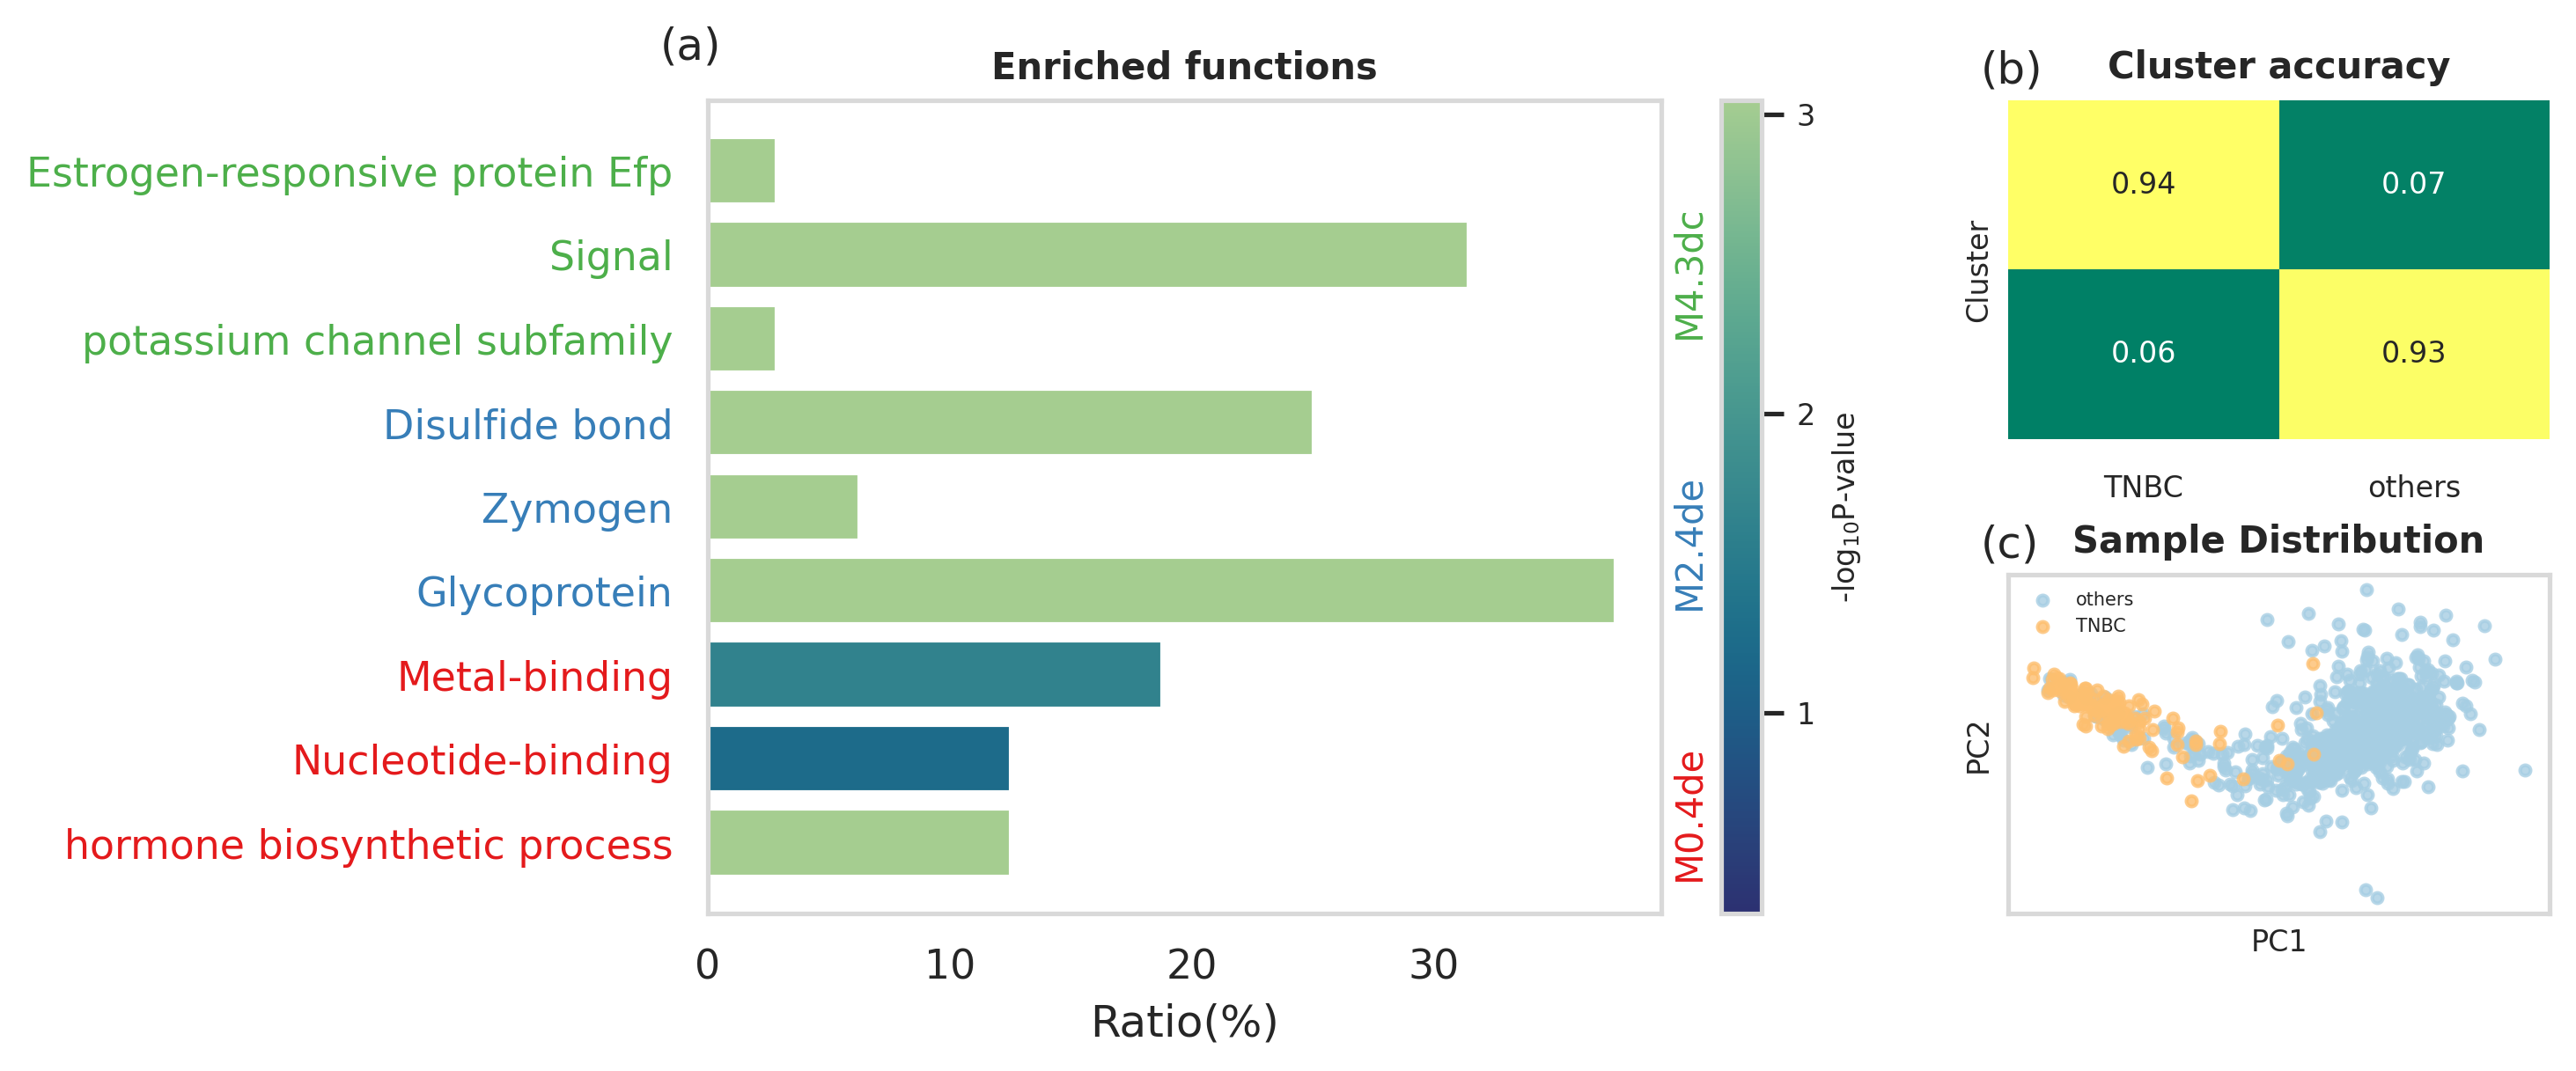

In [376]:
# vis
sns.set_theme(style='white')
sns.set_style(style={'axes.edgecolor': '.85',})
f = plt.figure(dpi=300,figsize=(9,4))
aspec = f.add_gridspec(
        nrows=2, ncols=3, 
#         wspace=0.6, 
        hspace=0.4
)
ax_func = f.add_subplot(aspec[0:2, 0:2])
ax_heat = f.add_subplot(aspec[0,2])
ax_scatter = f.add_subplot(aspec[1,2])
Fig_SampleFeature(sf,Rde.pheno,ax=ax_scatter,s=8)
ax_scatter.legend(edgecolor ='#ffffff',fontsize=5,markerscale =1)
ax_scatter.set_xticks([])
ax_scatter.set_yticks([])
ax_scatter.set_xlabel('PC1',fontsize=8)
ax_scatter.set_ylabel('PC2',fontsize=8)
ax_scatter.set_title('Sample Distribution',fontsize=10,fontweight='semibold')

sns.heatmap(
    pd.crosstab(label,Rde.pheno,normalize='columns'),
    annot=True,fmt='.2f',
    ax=ax_heat,cmap=plt.get_cmap('summer'),
    annot_kws={'fontsize':8},
    cbar=False
)
ax_heat.set_ylabel('Cluster',fontsize=8)
ax_heat.set_yticks([])
ax_heat.set_xlabel('')
ax_heat.set_xticklabels(['TNBC','others'],fontsize=8)
ax_heat.set_title('Cluster accuracy',fontsize=10,fontweight='semibold')

Fig_function(ax_func)
ax_func.set_title('Enriched functions',fontsize=10,fontweight='semibold')

for fid,ax in zip(['a','b','c'],[ax_func,ax_heat,ax_scatter]):
    ax.text(
        x=-0.05,y=1.05,
        s=f"({fid})",
        transform=ax.transAxes,
    )
f.savefig('./Result_file/TNBC_moduel.pdf',bbox_inches='tight')

In [ ]:
reflabels.loc[reflabels.index[reflabels['TNBC']=='others'] & label[label==0].index]